# Infer ***lipid droplets*** - part 9️⃣

--------------

## OVERVIEW
In notesbooks 4-9, we will go how each organelle is segmented. These segmentation workflows are completely independent of each other and can be run in any order. Additionally, the entire image will be processed in this notebook, irrespective of the single cells identified in notebooks 1-3. The cell mask will be applied to the organelle segmentation outputs before quantification (as outlined in [10_regionprops](./10_regionprops.ipynb)). 

This notebook goes through the workflow steps to segment the ***lipid droplets*** -- one of the six organelles of interest.

## OBJECTIVE: 
### ✅ Infer sub-cellular component ***lipid droplets***
Segment the ***lipid droplets*** from a single channel (neutrolipid dye). This workflow was optimized for images of the fluorescently dye BODIPY. 


## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from typing import Optional
import numpy as np


from aicssegmentation.core.pre_processing_utils import image_smoothing_gaussian_slice_by_slice
from aicssegmentation.core.utils import hole_filling
from skimage.measure import label

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))


from infer_subc.core.file_io import (read_czi_image,
                                                                    read_ome_image,
                                                                    export_inferred_organelle,
                                                                    import_inferred_organelle,
                                                                    list_image_files)

from infer_subc.core.img import *
from infer_subc.organelles import get_cellmask, get_nuclei, get_cytoplasm
# NOTE:  these "constants" are only accurate for the testing MCZ dataset
from infer_subc.constants import (TEST_IMG_N,
                                                                    NUC_CH ,
                                                                    LYSO_CH ,
                                                                    MITO_CH ,
                                                                    GOLGI_CH ,
                                                                    PEROX_CH ,
                                                                    ER_CH ,
                                                                    LD_CH ,
                                                                    RESIDUAL_CH )  

%load_ext autoreload
%autoreload 2

## Get and load Image for processing

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) /  "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "raw"
im_type = ".czi"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "out"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


---------------------

## infer ***lipid droplet*** 

## summary of steps 

➡️ INPUT
- select single channel containing the lysosome marker (channel number = user input)

PRE-PROCESSING
- rescale image intensities: 
    - min=0, max=1
- smooth image:
    - median filter (media size = user input)
    - gaussian filter (sigma = user input)

COREPROCESSING
   - apply an "otsu" threshold

POST-PROCESSING
  - fill holes (hole size = user input)
  - remove small objects (object size = user input)

OUTPUT ➡️
- label unique lysosome objects based on connectivity
- save labeled ***lipid droplet*** (lyso, LS) as unsigned integer 16-bit tif files

## EXTRACT prototype

In [4]:
###################
# INPUT
###################
raw_LD = select_channel_from_raw(img_data, LD_CH)

## PRE-PROCESSING prototype

In [5]:
###################
# PRE_PROCESSING
###################
median_sz = 2
gauss_sig = 1.34

struct_img =  scale_and_smooth(raw_LD,
                               median_size = median_sz, 
                               gauss_sigma = gauss_sig)


## CORE PROCESSING prototype

In [6]:
###################
# CORE_PROCESSING
###################
method = "otsu"
threshold_factor = 0.8
thresh_min = 0.05
thresh_max = 1.0
otsu_thresholded = apply_threshold(struct_img, 
                                   method= method, 
                                   thresh_factor=threshold_factor, 
                                   thresh_min=thresh_min, 
                                   thresh_max=thresh_max)

## POST-PROCESSING prototype

In [7]:
###################
# POST_PROCESSING
###################
hole_min_width = 0
hole_max_width = 2.5

small_object_width = 1

fill_filter_method = "3D"

cleaned_img2 = fill_and_filter_linear_size(otsu_thresholded, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size=small_object_width,
                                           method=fill_filter_method)

## LABELING prototype

In [8]:
###################
# LABELING
###################
LD_labels = label_uint16(cleaned_img2)

In [9]:
LD_labels.dtype

dtype('uint16')

## Visualize with `napari`
Visualize the first-pass segmentation and labeling with `napari`.

In [10]:
viewer = napari.Viewer()

31-May-23 18:08:16 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1090x686+1637+984 (frame: 1108x733+1628+946) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1365x859+1638+991 (frame: 1383x906+1629+953) margins: 9, 38, 9, 9 minimum size: 612x589 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=630,636 maxtrack=0,0)


In [11]:
viewer.add_image(
    struct_img)    

viewer.add_image(
    cleaned_img2,
    opacity=0.3,)

viewer.add_labels(
    LD_labels,
    opacity=0.3)

<Labels layer 'LD_labels' at 0x26f8ceef280>

## SAVE inferred lipid droplet to .tif file

In [12]:
out_file_n = export_inferred_organelle(LD_labels, "lyso", meta_dict, out_data_path)

saved file: a24hrs-Ctrl_14_Unmixing-lyso


----------
## DEFINE `_infer_LD` function

Based on the _prototyping_ above define the function to infer the lipid droplet.  

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [13]:
##########################
#  infer_LD
##########################
def _infer_LD(
            in_img: np.ndarray,
            LD_ch: str,
            median_sz: int,
            gauss_sig: float,
            method: str,
            thresh_factor: float,
            thresh_min: float,
            thresh_max: float,
            min_hole_w: int,
            max_hole_w: int,
            small_obj_w: int,
            fill_filter_method: str
            ) -> np.ndarray:
    """
    Procedure to infer peroxisome from linearly unmixed input.

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels
    median_sz: 
        width of median filter for signal
    gauss_sig: 
        sigma for gaussian smoothing of  signal
    method: 
        method for applying threshold.  "otsu"  or "li", "triangle", "median", "ave", "sauvola","multi_otsu","muiltiotsu"
    thresh_factor:
        scaling value for threshold
    thresh_min:
        absolute minumum for threshold
    thresh_max:
        absolute maximum for threshold
    max_hole_w: 
        hole filling cutoff for lipid post-processing
    small_obj_w: 
        minimu object size cutoff for lipid post-processing
    Returns
    -------------
    peroxi_object
        mask defined extent of peroxisome object
    """

    ###################
    # EXTRACT
    ###################    
    lipid = select_channel_from_raw(in_img, LD_ch)
    
    ###################
    # PRE_PROCESSING
    ###################                         
    lipid =  scale_and_smooth(lipid,
                              median_size = median_sz, 
                              gauss_sigma = gauss_sig)


    ###################
    # CORE_PROCESSING
    ###################
    bw = apply_threshold(lipid, 
                        method= method, 
                        thresh_factor=thresh_factor, 
                        thresh_min=thresh_min, 
                        thresh_max=thresh_max)


    ###################
    # POST_PROCESSING
    ###################
    # min_hole_w = 0
    struct_obj = fill_and_filter_linear_size(bw, 
                                             hole_min=min_hole_w, 
                                             hole_max=max_hole_w, 
                                             min_size=small_obj_w,
                                             method=fill_filter_method)

    ###################
    # LABELING
    ###################
    struct_obj1 = label_uint16(struct_obj)

    return struct_obj1

In [14]:
##########################
#  fixed_infer_LD
##########################
def _fixed_infer_LD(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: 
        a 3d image containing all the channels

    Returns
    -------------
    LD_body_object
        mask defined extent of liipid body

    """
    LD_ch = 6
    median_sz = 2   
    gauss_sig = 1.34
    method = "otsu"
    threshold_factor = 0.8
    thresh_min = 0.05
    thresh_max = 1.0
    min_hole_w = 0
    max_hole_w = 2.5
    small_obj_w = 1
    fill_filter_method = "3D"

    return _infer_LD(
        in_img,
        LD_ch,  
        median_sz, 
        gauss_sig, 
        method, 
        threshold_factor, 
        thresh_min, 
        thresh_max, 
        min_hole_w,
        max_hole_w, 
        small_obj_w,
        fill_filter_method)


# TEST  `infer_LD_body` function

In [15]:
_LD_obj =  _fixed_infer_LD(img_data) 

_LD_obj.dtype

dtype('uint16')

In [16]:
np.all(LD_labels == _LD_obj)

True

---------------------
# TEST `infer_LD` exported functions

The prototype `_infer_LD` was copied to the [`.organelles.lipid`](../infer_subc/organelles/lipid.py) sub-module.

In [17]:
from infer_subc.organelles import fixed_infer_LD

LD_obj =  fixed_infer_LD(img_data) 

In [18]:
np.all(_LD_obj == LD_obj)

True

## Visualize  2


In [19]:
viewer.add_image(
    _LD_obj,
    opacity=0.3)

viewer.add_labels(
    LD_obj,
    opacity=0.3)

<Labels layer 'LD_obj' at 0x26fa26f7e80>

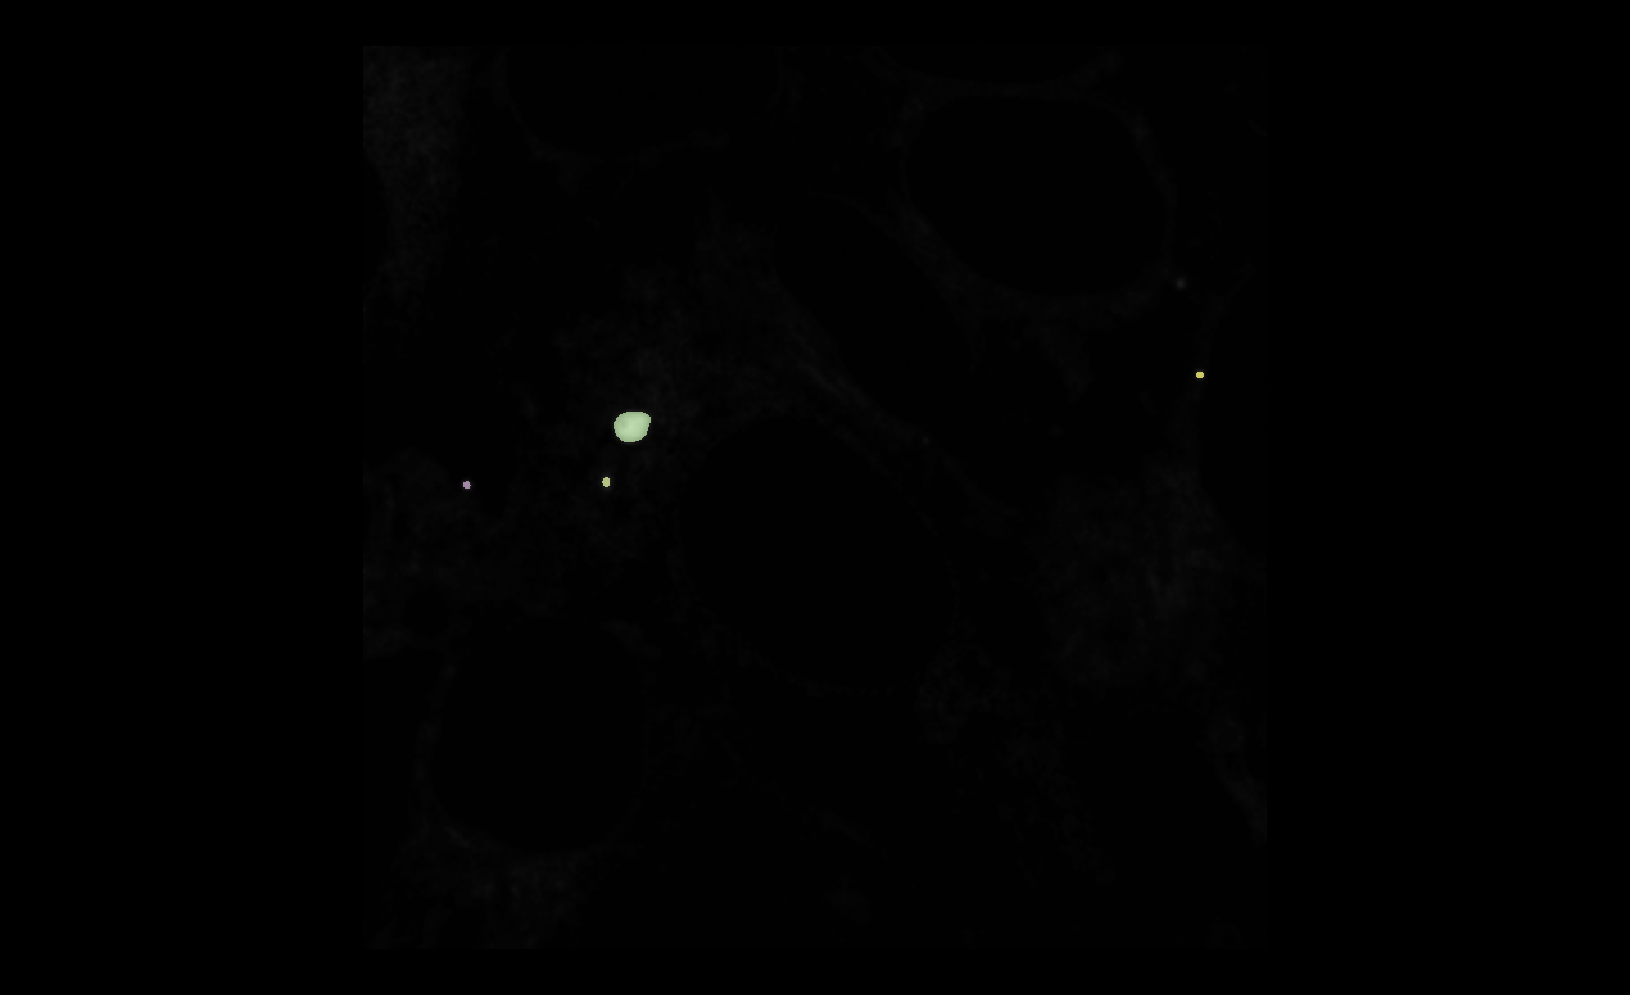

In [20]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [21]:
viewer.close()

-------------
## SUMMARY

The above details how the endoplasmic lipid droplet is inferred.  

###  THATS IT -- All segementation has been completed!

### NEXT: Quantification

proceed to [10_regionprops.ipynb](./10_regionprops.ipynb)
